In [1]:
import csv
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture

### Functions

In [2]:
def get_age_group(age):
    if age >= 0 and age <= 10:
        return 1
    elif age >= 11 and age <= 20:
        return 2
    elif age >= 21 and age <= 30:
        return 3
    elif age >= 31 and age <= 40:
        return 4
    elif age >= 41 and age <= 50:
        return 5
    elif age >= 51 and age <= 60:
        return 6
    elif age >= 61 and age <= 70:
        return 7
    elif age >= 71 and age <= 80:
        return 8
    elif age >= 81:
        return 9

In [3]:
def get_smoking_group(smoking_history):
    if smoking_history == 'never':
        return 1
    elif smoking_history == 'No Info':
        return 2
    else:
        return 3

In [4]:
# gender group contains 'other', modified by Jiangqin
def get_gender_group(gender):
    if gender == 'Female':
        return 1
    elif gender == 'Male':
        return 2
    elif gender == 'Other':
        return 3

### Data Cleanup

In [5]:
# load diabetes dataset
path = 'diabetes_prediction_dataset.csv'

data = pd.read_csv(path)
print(data.shape)

data.dropna(inplace=True)
print(data.shape)
data.drop_duplicates()
print(data.shape)
data["age_group"] = data["age"].apply(get_age_group)
data["smoking_group"] = data["smoking_history"].apply(get_smoking_group)
data["gender_group"] = data["gender"].apply(get_gender_group)
print(data.head())


(100000, 9)
(100000, 9)
(100000, 9)
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  age_group  smoking_group  \
0          6.6                  140         0          8              1   
1          6.6                   80         0          6              2   
2          5.7                  158         0          3              1   
3          5.0                  155         0          4              3   
4          4.8                  155         0          8              3   

   gender_group  
0             1  
1             1  
2             2  
3             

### Correlation Analysis

In [6]:
data['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [7]:
diabetes=data[['diabetes']]
diabetes

,diabetes
0,0
1,0
2,0
3,0
4,0
...,...
99995,0
99996,0
99997,0
99998,0


In [8]:
data.drop(columns=['diabetes','gender','age','smoking_history'],inplace=True)
data['diabetes']=diabetes
data


,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,age_group,smoking_group,gender_group,diabetes
0,0,1,25.19,6.6,140,8,1,1,0
1,0,0,27.32,6.6,80,6,2,1,0
2,0,0,27.32,5.7,158,3,1,2,0
3,0,0,23.45,5.0,155,4,3,1,0
4,1,1,20.14,4.8,155,8,3,2,0
...,...,...,...,...,...,...,...,...,...
99995,0,0,27.32,6.2,90,8,2,1,0
99996,0,0,17.37,6.5,100,1,2,1,0
99997,0,0,27.83,5.7,155,7,3,2,0
99998,0,0,35.42,4.0,100,3,1,1,0


In [9]:
corr=data.corr()
corr

,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,age_group,smoking_group,gender_group,diabetes
hypertension,1.000000,0.121262,0.147666,0.080939,0.084429,0.249825,0.015438,0.014203,0.197823
heart_disease,0.121262,1.000000,0.061198,0.067589,0.070066,0.229630,0.068298,0.077696,0.171727
bmi,0.147666,0.061198,1.000000,0.082997,0.091261,0.337632,0.029798,-0.022994,0.214357
HbA1c_level,0.080939,0.067589,0.082997,1.000000,0.166733,0.101987,0.014829,0.019957,0.400660
blood_glucose_level,0.084429,0.070066,0.091261,0.166733,1.000000,0.110571,0.016084,0.017199,0.419558
age_group,0.249825,0.229630,0.337632,0.101987,0.110571,1.000000,0.089520,-0.028755,0.258168
smoking_group,0.015438,0.068298,0.029798,0.014829,0.016084,0.089520,1.000000,0.085723,0.038803
gender_group,0.014203,0.077696,-0.022994,0.019957,0.017199,-0.028755,0.085723,1.000000,0.037411
diabetes,0.197823,0.171727,0.214357,0.400660,0.419558,0.258168,0.038803,0.037411,1.000000


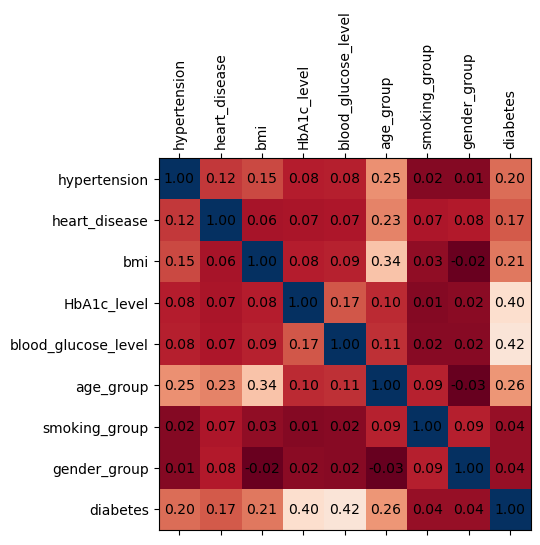

<Figure size 640x480 with 0 Axes>

In [10]:
plt.matshow(corr,cmap='RdBu')
plt.xticks(np.arange(len(corr)),corr.columns, rotation='vertical')
plt.yticks(np.arange(len(corr)),corr.columns)
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(i,j,f'{corr.iloc[i,j]:.2f}',va='center',ha='center')
plt.show()
plt.clf()

In [11]:
#from the plot above we can see that no significant multilinearity exist, so we don't need to perform PCA

In [12]:
data.isnull().sum()

hypertension           0
heart_disease          0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
age_group              0
smoking_group          0
gender_group           0
diabetes               0
dtype: int64

### Mutual Info Regression

In [13]:
from sklearn.feature_selection import  mutual_info_regression

In [14]:
MI=mutual_info_regression(data.iloc[:,:-1],data.iloc[:,-1])
MI
for i in range(len(MI)):
    print(f'{data.columns[i]} : {MI[i]}')

hypertension : 0.014409101952000292
heart_disease : 0.007599915616729902
bmi : 0.021783753933439343
HbA1c_level : 0.1301860639946124
blood_glucose_level : 0.11071929995561547
age_group : 0.03873503495029329
smoking_group : 0.009602899685338784
gender_group : 0.0


In [15]:
adict={}
for i in range(len(MI)):
    adict[data.columns[i]]= round(MI[i],4)
sorted_MI=dict(sorted(adict.items(),key=lambda item:item[1],reverse=True))
sorted_MI

{'HbA1c_level': 0.1302,
 'blood_glucose_level': 0.1107,
 'age_group': 0.0387,
 'bmi': 0.0218,
 'hypertension': 0.0144,
 'smoking_group': 0.0096,
 'heart_disease': 0.0076,
 'gender_group': 0.0}

In [16]:
# gender_group MI scores is very low, close to 0. so don't select this  feature.
# compare the performance between before feature selection and after feature selection

### Logistic Regression

In [17]:
# use all the features
# apply logistic regression model

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [19]:
xtrain,xtest,ytrain,ytest=train_test_split(data.iloc[:,:-1],data.iloc[:,-1],random_state=42)

In [20]:
logistic1=LogisticRegression().fit(xtrain,ytrain)
logistic1.score(xtest,ytest)

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.92976

In [21]:
# after feature selection
# apply logistic regression model

In [22]:
new_data=data[['hypertension','heart_disease','bmi','HbA1c_level','blood_glucose_level','age_group','smoking_group','diabetes']]

In [23]:
xtrain,xtest,ytrain,ytest=train_test_split(new_data.iloc[:,:-1],new_data.iloc[:,-1],random_state=42)

In [24]:
logistic1=LogisticRegression().fit(xtrain,ytrain)
logistic1.score(xtest,ytest)

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.939

In [25]:
# use feature selection technique improve the performance
#so use the new dataset after feature selection new_data

In [26]:
new_data

,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,age_group,smoking_group,diabetes
0,0,1,25.19,6.6,140,8,1,0
1,0,0,27.32,6.6,80,6,2,0
2,0,0,27.32,5.7,158,3,1,0
3,0,0,23.45,5.0,155,4,3,0
4,1,1,20.14,4.8,155,8,3,0
...,...,...,...,...,...,...,...,...
99995,0,0,27.32,6.2,90,8,2,0
99996,0,0,17.37,6.5,100,1,2,0
99997,0,0,27.83,5.7,155,7,3,0
99998,0,0,35.42,4.0,100,3,1,0


### Outlier Removal

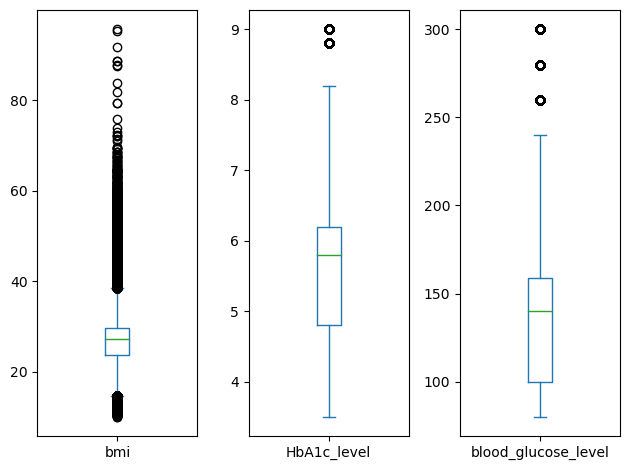

In [27]:
box=['bmi','HbA1c_level','blood_glucose_level']
new_data[box].plot(kind='box',subplots=True)
plt.tight_layout()

#### One Class SVM

In [28]:
# outlier removal - OneClass SVM
from sklearn.svm import OneClassSVM

In [29]:
%%time
# xtrain = scaler.fit_transform(xtrain)
oneclass = OneClassSVM(nu=.1).fit(new_data)
pred = oneclass.predict(new_data)

CPU times: user 2min 12s, sys: 1.77 s, total: 2min 14s
Wall time: 2min 15s


In [30]:
np.unique(pred,return_counts=True)

(array([-1,  1]), array([ 9996, 90004]))

In [31]:
#outliers accourding to OneClass SVM
OCSvm_Outliers = new_data[pred==-1]
OCSvm_Outliers

,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,age_group,smoking_group,diabetes
6,0,0,19.31,6.5,200,5,1,1
38,1,0,27.32,5.7,260,5,3,1
39,0,0,56.43,6.2,200,4,1,0
87,0,0,32.27,6.2,220,4,3,1
89,0,0,16.39,6.6,200,1,2,0
...,...,...,...,...,...,...,...,...
99954,0,0,27.32,6.0,80,8,2,0
99957,0,0,34.45,6.5,280,7,2,1
99962,1,0,38.31,7.0,200,6,1,1
99969,0,0,22.88,4.5,80,3,1,0


In [32]:
new_data.loc[:,'HbA1c_level'].count()

100000

Text(0, 0.5, 'blood_glucose_level')

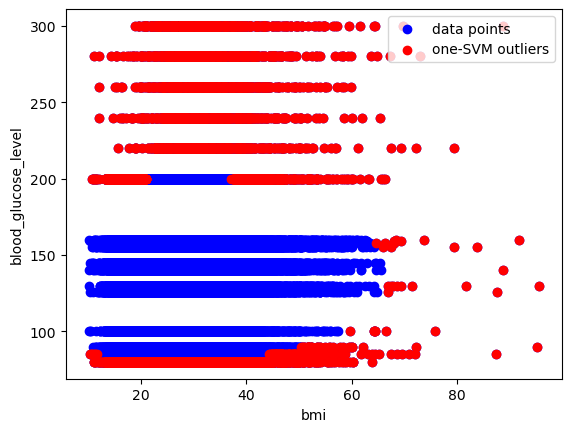

In [33]:

plt.scatter(new_data.loc[:,'bmi'],new_data.loc[:,'blood_glucose_level'],color='blue',label='data points')
plt.scatter(OCSvm_Outliers.loc[:,'bmi'],OCSvm_Outliers.loc[:,'blood_glucose_level'],color='red',label='one-SVM outliers')
plt.legend(loc='upper right')
plt.xlabel('bmi')
plt.ylabel('blood_glucose_level')

#### Local Outlier Factor

In [34]:
#outlier removal - Local outlier factor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [35]:
%%time
# to find n used info fro here: https://datascience.stackexchange.com/questions/47048/how-to-decide-how-many-n-neighbors-to-consider-while-implementing-localoutlierfa

n = 30 # Max number of neighbours you want to consider
param_grid = {'n_neighbors': np.arange(n)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid)
grid.fit(xtrain, ytrain)

CPU times: user 1min 18s, sys: 613 ms, total: 1min 19s
Wall time: 1min 19s


/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_const

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [36]:
param_grid

{'n_neighbors': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])}

In [37]:
grid.best_params_
#9 seems to be the best n to use, also seems like the payoff of increasing past here is not very good

{'n_neighbors': 4}

In [38]:
%%time
clf = LocalOutlierFactor(n_neighbors=9)
lof = clf.fit_predict(new_data)

CPU times: user 1.58 s, sys: 10.9 ms, total: 1.59 s
Wall time: 1.59 s


In [39]:
np.unique(lof, return_counts = True)

(array([-1,  1]), array([ 9976, 90024]))

In [40]:
#outliers according to LOF
LOF_Outliers = new_data[lof == -1]
LOF_Outliers

,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,age_group,smoking_group,diabetes
27,0,0,27.85,5.8,80,4,3,0
28,1,0,26.47,4.0,158,5,1,0
52,0,0,28.12,5.0,100,8,2,0
53,0,0,27.32,7.0,159,6,3,1
60,1,0,27.86,6.6,145,5,3,0
...,...,...,...,...,...,...,...,...
99952,0,0,27.70,6.2,80,6,3,0
99954,0,0,27.32,6.0,80,8,2,0
99983,0,0,27.32,5.7,126,3,2,0
99990,0,0,27.32,6.1,100,4,2,0


In [41]:
#do they overlap?
np.unique(lof == pred, return_counts=True)

(array([False,  True]), array([19154, 80846]))

Text(0, 0.5, 'blood_glucose_level')

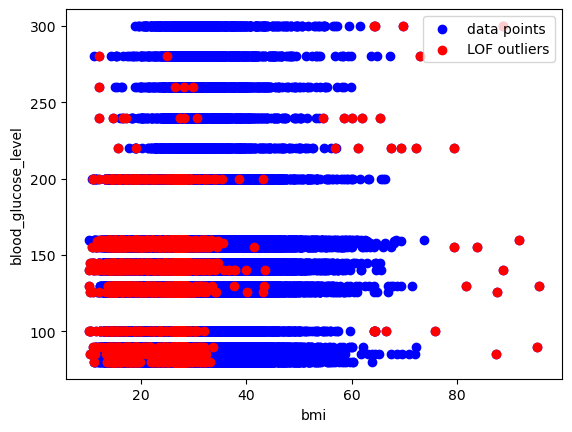

In [42]:

plt.scatter(new_data.loc[:,'bmi'],new_data.loc[:,'blood_glucose_level'],color='blue',label='data points')
plt.scatter(LOF_Outliers.loc[:,'bmi'],LOF_Outliers.loc[:,'blood_glucose_level'],color='red',label='LOF outliers')
plt.legend(loc='upper right')
plt.xlabel('bmi')
plt.ylabel('blood_glucose_level')

In [43]:
len(LOF_Outliers)

9976

In [44]:
len(OCSvm_Outliers)

9996

#### One Class SVM Outliers removed dataset

In [45]:
OCSvm_Inliers = new_data[pred ==1]
len(OCSvm_Inliers)

90004

In [46]:
OCS_xtrain, OCS_xtest, OCS_ytrain,OCS_ytest=train_test_split(OCSvm_Inliers.iloc[:,:-1],OCSvm_Inliers.iloc[:,-1],random_state=42)
OCS_xtrain
# len(OCS_xtrain)

,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,age_group,smoking_group
79915,0,0,27.32,4.8,200,2,2
5669,1,0,33.48,4.5,140,5,3
78011,1,0,27.32,4.8,155,8,3
63368,0,0,25.30,6.0,130,3,1
2364,1,0,27.32,6.6,155,7,1
...,...,...,...,...,...,...,...
7010,0,0,25.55,6.1,160,3,3
61074,0,0,29.65,8.8,145,7,3
85333,0,0,27.32,6.6,80,4,2
937,0,1,15.06,6.6,140,8,1


### LOF Outliers removed dataset

In [47]:
LOF_Inliers = new_data[lof ==1]
len(LOF_Inliers)

90024

In [48]:
LOF_xtrain,LOF_xtest,LOF_ytrain,LOF_ytest=train_test_split(LOF_Inliers.iloc[:,:-1],LOF_Inliers.iloc[:,-1],random_state=42)
LOF_xtrain
# len(LOF_xtrain)

,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,age_group,smoking_group
59100,0,0,26.57,3.5,80,4,1
26735,0,0,40.97,3.5,200,6,3
48984,0,0,27.32,5.8,159,3,2
55017,0,0,31.74,4.5,145,3,3
57560,0,0,27.32,6.1,100,1,2
...,...,...,...,...,...,...,...
6935,0,0,42.88,3.5,85,5,1
60908,0,0,18.67,6.2,90,2,2
85319,0,0,20.19,5.0,140,6,3
938,0,0,16.87,6.5,85,1,1


### KMeans Model

In [49]:
# true lables in the dataset
data_true_labels = LOF_Inliers['diabetes']

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


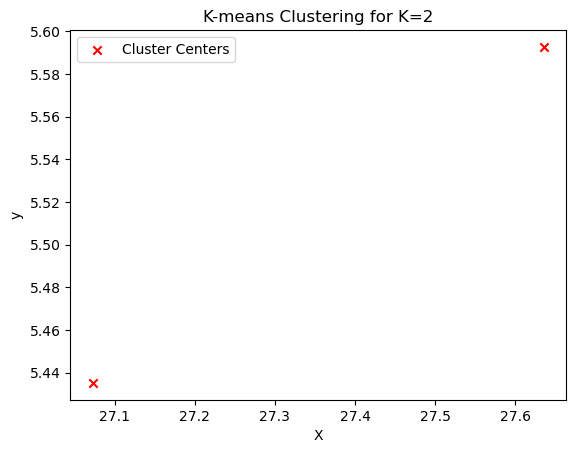

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


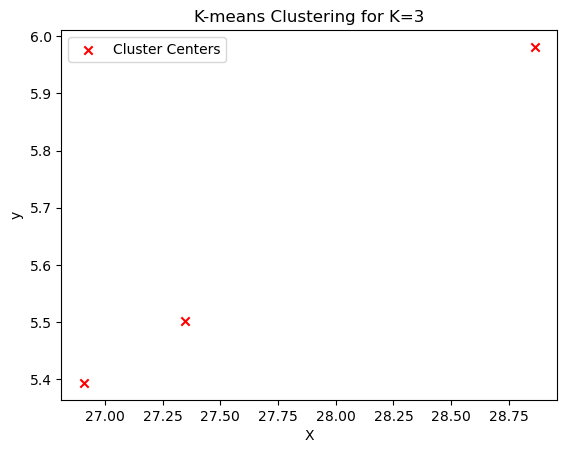

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


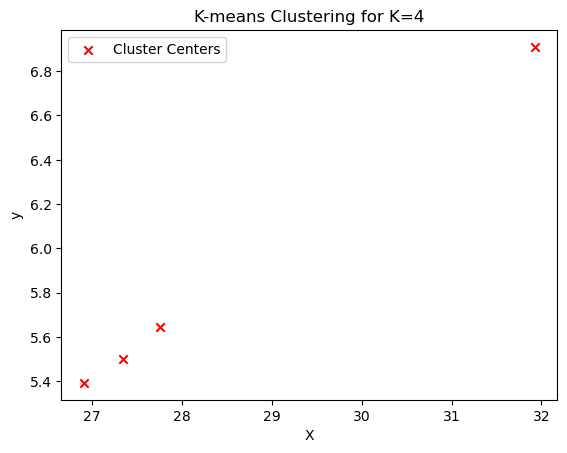

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


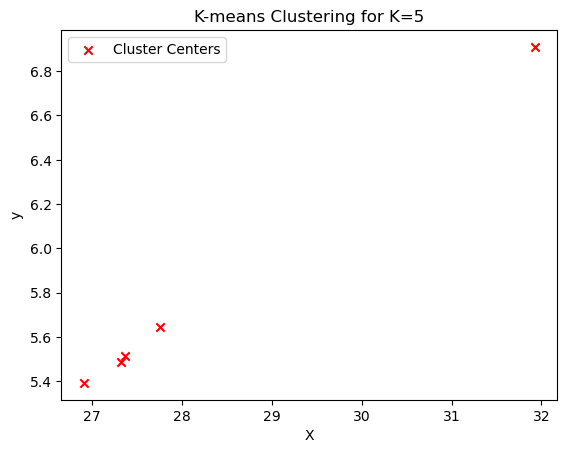

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


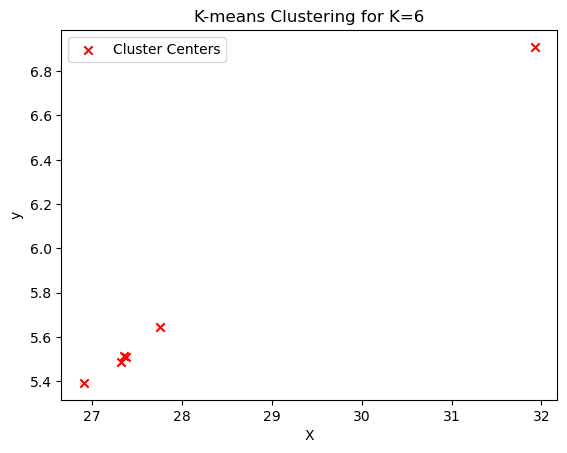

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


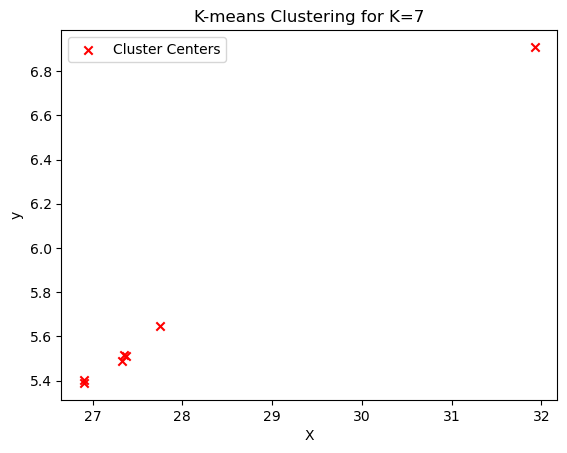

[69070772.28592283, 25345327.23809687, 15979335.909187835, 8866126.015554681, 7417776.447196828, 6349600.51929209]
[0.5332252662721992, 0.6803331950022394, 0.6709470070343041, 0.6204365387483645, 0.5850461656663155, 0.5273108083528547]
[-0.01098101940360713, 0.0655835950856884, 0.07754909944829967, 0.04943880894245159, 0.04596836227856311, 0.03146245410716246]


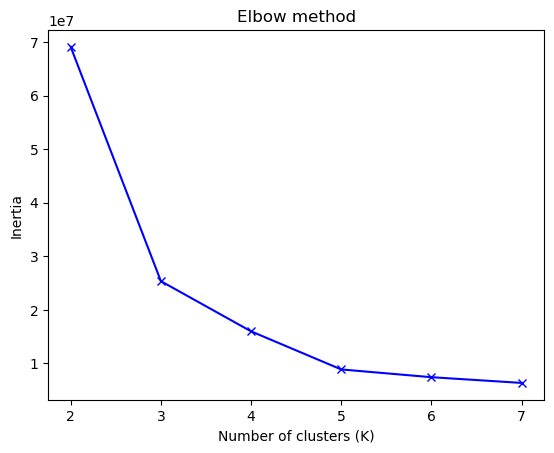

In [50]:
feature_columns = ['bmi', 'HbA1c_level', 'blood_glucose_level']

X = LOF_Inliers[feature_columns]
X.head()

inertias = []
sil_scores = []
rand_scores = []

clusters = range(2,8)

for k in clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    kmeans_predicted_labels = kmeans.labels_
    
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)
    rand_scores.append(adjusted_rand_score(data_true_labels, kmeans_predicted_labels))
    
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', color='red', label='Cluster Centers')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('K-means Clustering for K='+str(k))
    plt.legend()
    plt.show()

print(inertias)
print(sil_scores)
print(rand_scores)

plt.plot(clusters, inertias, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

### GMM Model

In [51]:
np.random.seed(64)

iterations = []
log_likelihoods = []
sil_scores_gmm = []
aic_gmm = []
bic_gmm = []
mismatch_rates = []

for i in range(2,8):
    gmm = GaussianMixture(n_components=i, max_iter=50, tol=1e-3)
    gmm.fit(X)
    gmm_clusters_labels = gmm.predict(X)
    
    log_likelihoods.append(gmm.lower_bound_)
    iterations.append(i)
    sil_scores_gmm.append(silhouette_score(X, gmm_clusters_labels))
    mismatch_rate = len(data_true_labels[data_true_labels != gmm_clusters_labels])/len(data_true_labels)
    mismatch_rates.append(mismatch_rate)
    aic_gmm.append(gmm.aic(X))
    bic_gmm.append(gmm.bic(X))

print(log_likelihoods)
print(sil_scores_gmm)
print(mismatch_rates)
print(aic_gmm)
print(bic_gmm)

[-9.883529562659014, -9.603192271607213, -8.860158465759454, -8.547520655185453, -8.543846697568998, -8.53218792509032]
[0.6399587982037682, 0.6803331950022394, 0.6598428483120631, 0.6144024305497655, 0.618319962036816, 0.5454011010090513]
[0.04979783168932729, 0.39437261174797833, 0.43648360437216743, 0.7188305340798009, 0.7115769128232471, 0.7254732071447614]
[1779223.958678574, 1729047.4984865463, 1595331.811414899, 1539059.5271152859, 1538419.4758404172, 1536154.3486703937]
[1779402.7074786022, 1729320.3256023787, 1595698.716846536, 1539520.510862727, 1538974.5379036625, 1536803.4890494433]


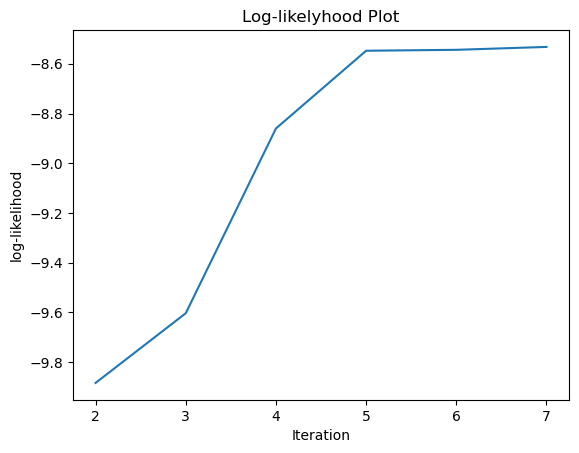

In [52]:
plt.plot(iterations, log_likelihoods)
plt.xlabel('Iteration')
plt.ylabel('log-likelihood')
plt.title('Log-likelyhood Plot')
plt.show()

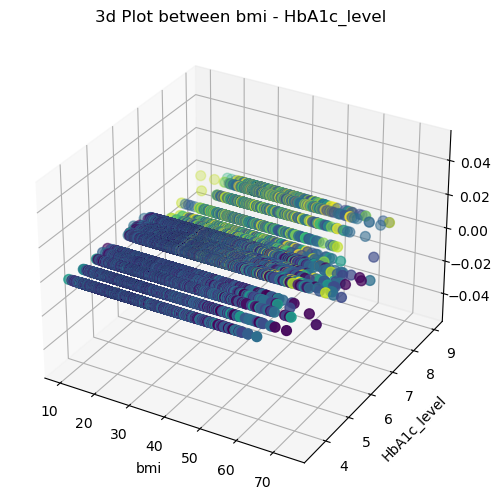

In [53]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
f1 = X['bmi']
f2 = X['HbA1c_level']
f3 = X['blood_glucose_level']

ax.scatter(f1, f2, c=f3, cmap='viridis', marker='o', s=50)
plt.xlabel('bmi')
plt.ylabel('HbA1c_level')
plt.title('3d Plot between bmi - HbA1c_level')
plt.show()

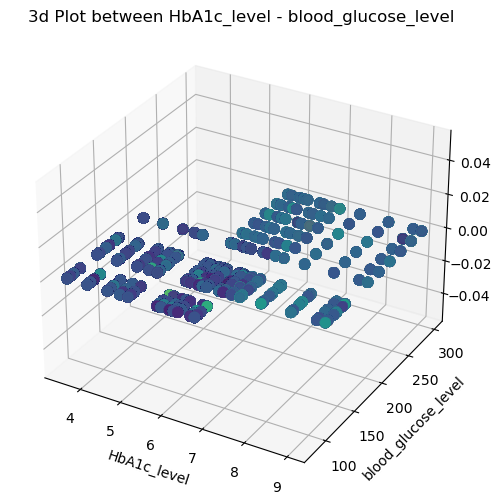

In [54]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
f1 = X['bmi']
f2 = X['HbA1c_level']
f3 = X['blood_glucose_level']

ax.scatter(f2, f3, c=f1, cmap='viridis', marker='o', s=50)
plt.xlabel('HbA1c_level')
plt.ylabel('blood_glucose_level')
plt.title('3d Plot between HbA1c_level - blood_glucose_level')
plt.show()

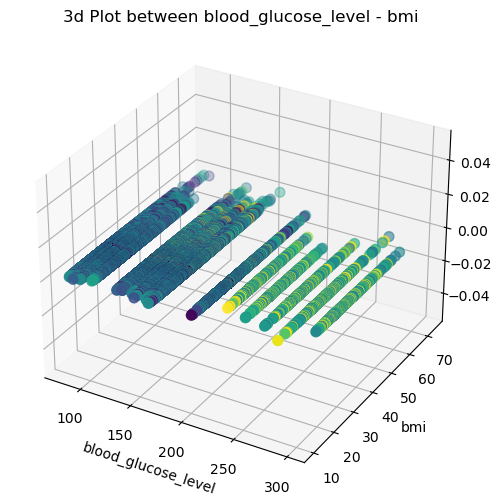

In [55]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
f1 = X['bmi']
f2 = X['HbA1c_level']
f3 = X['blood_glucose_level']

ax.scatter(f3, f1, c=f2, cmap='viridis', marker='o', s=50)
plt.xlabel('blood_glucose_level')
plt.ylabel('bmi')
plt.title('3d Plot between blood_glucose_level - bmi')
plt.show()

In [56]:
# Define a function to plot the Gaussian model
def plot_gaussian_model(gmm, data):
    x = np.linspace(min(data.iloc[:, 0]), max(data.iloc[:, 0]), 100)
    y = np.linspace(min(data.iloc[:, 1]), max(data.iloc[:, 1]), 100)
    X, Y = np.meshgrid(x, y)
    Z = -gmm.score_samples(np.array([X.ravel(), Y.ravel()]).T)
    Z = Z.reshape(X.shape)

    plt.contour(X, Y, Z, levels=np.logspace(0, 3, 10), cmap='viridis', alpha=0.6)

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


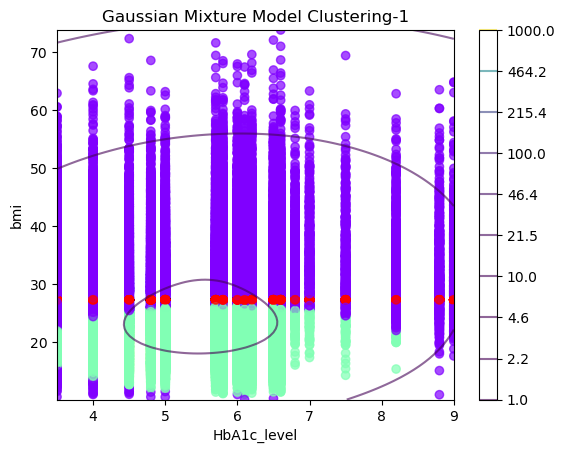

In [57]:
# fit gmm for HbA1c_level and bmi features
np.random.seed(62)
feature_columns_3 = ['HbA1c_level', 'bmi']

data_3 = X[feature_columns_3]

gmm_3 = GaussianMixture(n_components=3, max_iter=100, tol=1e-3)
gmm_3.fit(data_3)

cluster_labels_3 = gmm_3.predict(data_3)

# Plot the data points with colors representing different clusters
plt.scatter(data_3.iloc[:, 0], data_3.iloc[:, 1], c=cluster_labels_3, cmap='rainbow', alpha=0.7)

# Plot the Gaussian model contours
plot_gaussian_model(gmm_3, data_3)

# Add labels and title
plt.xlabel('HbA1c_level')
plt.ylabel('bmi')
plt.title('Gaussian Mixture Model Clustering-1')

# Show the plot
plt.colorbar()
plt.show()

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


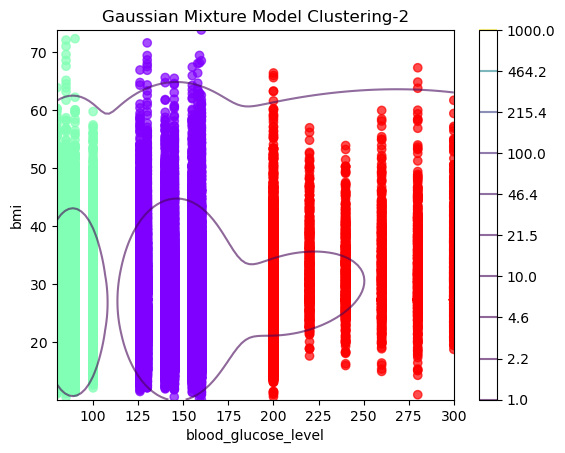

In [58]:
# fit gmm for blood_glucose_level and bmi features
np.random.seed(63)
feature_columns_4 = ['blood_glucose_level', 'bmi']
data_4 = X[feature_columns_4]

gmm_4 = GaussianMixture(n_components=3, max_iter=100, tol=1e-3)
gmm_4.fit(data_4)

cluster_labels_4 = gmm_4.predict(data_4)

# Plot the data points with colors representing different clusters
plt.scatter(data_4.iloc[:, 0], data_4.iloc[:, 1], c=cluster_labels_4, cmap='rainbow', alpha=0.7)

# Plot the Gaussian model contours
plot_gaussian_model(gmm_4, data_4)

# Add labels and title
plt.xlabel('blood_glucose_level')
plt.ylabel('bmi')
plt.title('Gaussian Mixture Model Clustering-2')

# Show the plot
plt.colorbar()
plt.show()

### KNN Model

#### One Class SVM Data

In [59]:
#using the same number of neighbors as the LOF model above
knn = KNeighborsClassifier(n_neighbors=9)

OCS_knn= knn.fit(OCS_xtrain, OCS_ytrain)
OCS_knn_score_train = OCS_knn.score(OCS_xtrain, OCS_ytrain)
OCS_knn_score_test = OCS_knn.score(OCS_xtest,OCS_ytest)

print('OCS Training Accuracy: ' + str(OCS_knn_score_train))
print('OCS Test Accuracy: ' + str(OCS_knn_score_test))

OCS Training Accuracy: 0.9611128394293587
OCS Test Accuracy: 0.9562686102839874


#### LOF Data

In [60]:
LOF_knn= knn.fit(LOF_xtrain, LOF_ytrain)
LOF_knn_score_train = LOF_knn.score(LOF_xtrain, LOF_ytrain)
LOF_knn_score_test = LOF_knn.score(LOF_xtest,LOF_ytest)

print('LOF Training Accuracy: ' + str(LOF_knn_score_train))
print('LOF Test Accuracy: ' + str(LOF_knn_score_test))

LOF Training Accuracy: 0.9685861548031636
LOF Test Accuracy: 0.9634319736959033


#### No Outliers Removed

In [61]:
knn= knn.fit(xtrain, ytrain)
knn_score_train = LOF_knn.score(xtrain, ytrain)
knn_score_test = LOF_knn.score(xtest,ytest)

print('All Data Training Accuracy: ' + str(knn_score_train))
print('All Data Test Accuracy: ' + str(knn_score_test))

All Data Training Accuracy: 0.9639733333333333
All Data Test Accuracy: 0.95848


### Logistic Regression with outliers removel

In [62]:
logistic2=LogisticRegression().fit(OCS_xtrain, OCS_ytrain)
logistic2.score(OCS_xtest,OCS_ytest)

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9521799031154171

In [63]:
logistic2=LogisticRegression().fit(LOF_xtrain, LOF_ytrain)
logistic2.score(LOF_xtest,LOF_ytest)

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9597885008442193

In [64]:
%%time
# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1.0,0.2,0.01],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500]
}

# Create an instance of the Logistic Regression model
model = LogisticRegression()

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(LOF_xtrain, LOF_ytrain)

# Print the best hyperparameters found by grid search
print("Best Hyperparameters: ", grid_search.best_params_)

# Evaluate the performance of the best model
best_model = grid_search.best_estimator_
best_model_score = best_model.score(LOF_xtest,LOF_ytest)
print("Best Model Score: ", best_model_score)

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/py

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/py

/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jiangqinma/miniconda3/lib/py

Best Hyperparameters:  {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Model Score:  0.9618324002488225
CPU times: user 8min 21s, sys: 2min 48s, total: 11min 10s
Wall time: 16min 51s


In [65]:
best_model.coef_

array([[0.97775407, 0.9826368 , 0.09709312, 2.14033878, 0.03467986,
        0.53842029, 0.05576454]])

In [66]:
LOF_xtrain.columns

Index(['hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'age_group', 'smoking_group'],
      dtype='object')

In [67]:
alist={}
for feature, coef in zip(LOF_xtrain.columns,best_model.coef_[0]):
    alist[feature]=coef
dict(sorted(alist.items(),key=lambda item:item[1],reverse=True))

{'HbA1c_level': 2.140338779867485,
 'heart_disease': 0.982636799312398,
 'hypertension': 0.977754072846645,
 'age_group': 0.5384202854475466,
 'bmi': 0.09709311761027807,
 'smoking_group': 0.055764535308901,
 'blood_glucose_level': 0.03467985516505443}

In [68]:
from sklearn.metrics import classification_report,confusion_matrix

In [69]:
print(classification_report(LOF_ytest,best_model.predict(LOF_xtest)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     20539
           1       0.86      0.67      0.75      1967

    accuracy                           0.96     22506
   macro avg       0.92      0.83      0.87     22506
weighted avg       0.96      0.96      0.96     22506



In [70]:
print(confusion_matrix(LOF_ytest,best_model.predict(LOF_xtest)))

[[20329   210]
 [  649  1318]]


In [71]:
import seaborn as sns

([<matplotlib.axis.YTick at 0x16c5f5630>,
 [Text(0, 0, 'negative'), Text(0, 1, 'possitive')])

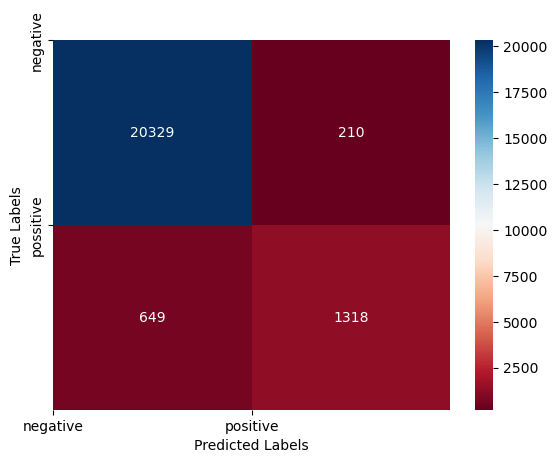

In [72]:
cm=confusion_matrix(LOF_ytest,best_model.predict(LOF_xtest))
plt.figure()
sns.heatmap(cm,annot=True,fmt='d',cmap='RdBu')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=[0,1],labels=['negative', 'positive'])
plt.yticks(ticks=[0,1],labels=['negative','possitive'])

In [73]:
best_model.predict_proba(LOF_xtest)

array([[0.97758283, 0.02241717],
       [0.99519281, 0.00480719],
       [0.91923291, 0.08076709],
       ...,
       [0.00547822, 0.99452178],
       [0.52876284, 0.47123716],
       [0.99885777, 0.00114223]])

In [74]:
from sklearn.metrics import roc_curve,roc_auc_score
y=best_model.predict_proba(LOF_xtest)[:,1]
fpr,tpr,thresholds=roc_curve(LOF_ytest,y)
auc=roc_auc_score(LOF_ytest,y)


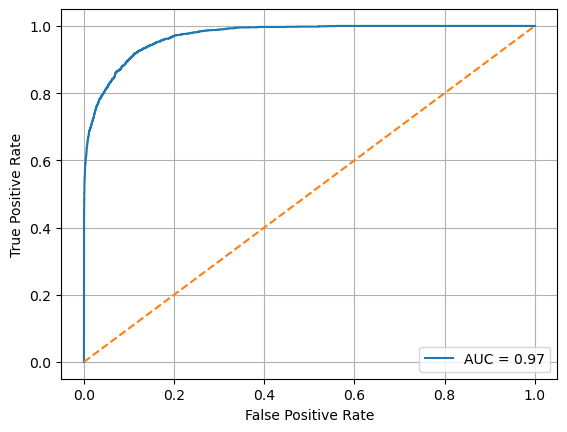

In [75]:
plt.plot(fpr,tpr,label=f'AUC = {auc:.2f}')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

In [76]:
best_model.score(LOF_xtest,LOF_ytest)

0.9618324002488225

In [77]:
#models training based on trees
#decision tree model1
#randomforest model2
#extra tree model3
#adaboost model 4

In [78]:
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [79]:
#decision tree
model1=DecisionTreeClassifier()
model2=RandomForestClassifier()
model3=ExtraTreesClassifier()
model4=AdaBoostClassifier()
model1.fit(LOF_xtrain, LOF_ytrain)
model2.fit(LOF_xtrain, LOF_ytrain)
model3.fit(LOF_xtrain, LOF_ytrain)
model4.fit(LOF_xtrain, LOF_ytrain)
scores1=model1.score(LOF_xtest,LOF_ytest)
scores2=model1.score(LOF_xtest,LOF_ytest)
scores3=model1.score(LOF_xtest,LOF_ytest)
scores4=model1.score(LOF_xtest,LOF_ytest)
print('Decision Tree model classification accuracy is ', scores1)
print('Random Forest model classification accuracy is ', scores2)
print('Extra Trees model classification accuracy is ', scores3)
print('AdaBoost model classification accuracy is ', scores4)

Decision Tree model classification accuracy is  0.9603661245889985
Random Forest model classification accuracy is  0.9603661245889985
Extra Trees model classification accuracy is  0.9603661245889985
AdaBoost model classification accuracy is  0.9603661245889985


In [80]:
importance_scores=model2.feature_importances_
importance_scores

array([0.02104912, 0.01326766, 0.16632965, 0.41184845, 0.33320622,
       0.04314665, 0.01115224])

In [81]:
newdict={}
for feature, importance in zip(LOF_xtrain.columns,importance_scores):
    newdict[feature]=importance
dict(sorted(newdict.items(),key=lambda item:item[1],reverse=True))

{'HbA1c_level': 0.41184845290845395,
 'blood_glucose_level': 0.33320622283036,
 'bmi': 0.16632965274804817,
 'age_group': 0.04314665358103084,
 'hypertension': 0.021049124041442196,
 'heart_disease': 0.013267656980658656,
 'smoking_group': 0.011152236910006235}